In [1]:
import os
import ntpath

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from PIL import ImageDraw
from PIL import ImageChops

import keras

import runai.ga

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib

from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical

import random

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from imgaug import augmenters as iaa

import cv2
import pandas as pd

In [2]:
np.random.seed(0)

In [3]:
( X_train_raw, y_train ), ( X_test_raw, y_test ) = mnist.load_data()

In [4]:
print( X_train_raw.shape )
print( X_test_raw.shape )
print( y_train.shape )
print( y_test.shape )

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [5]:
assert( X_train_raw.shape[ 0 ] == y_train.shape[ 0 ]), "Training data: #images != #labels"
assert( X_test_raw.shape[ 0 ] == y_test.shape[ 0 ]), "Testing data: #images != #labels"
assert( X_train_raw.shape[ 1: ] == ( 28, 28 ) ), "The dimensions of the images have to be 28x28."
assert( X_test_raw.shape[ 1: ] == ( 28, 28 ) ), "The dimensions of the images have to be 28x28."

In [6]:
source_x_size = X_train_raw.shape[1]
source_y_size = X_train_raw.shape[2]
target_x_size = 64
target_y_size = 64
print ("Target_x_size : ", source_x_size)
print ("Target_y_size : ", source_x_size)
print ("Source_x_size : ", target_x_size)
print ("Source_y_size : ", target_x_size)

Target_x_size :  28
Target_y_size :  28
Source_x_size :  64
Source_y_size :  64


In [7]:
# creates a new image with size (target_x_size, target_y_size)
# and puts the source image (img) at a random position into the
# new image. The source image must be smaller or same size as the
# new image.
def enlarge_image( img ):
    # ########################################################
    # source_x_size, source_y_size
    # target_x_size, target_y_size 
    enlarged = np.zeros( ( target_x_size, target_y_size ), np.uint8 )
    x_offset = random.randint( 0, target_x_size - source_x_size - 1 )
    y_offset = random.randint( 0, target_y_size - source_y_size - 1 )
    enlarged[ y_offset : y_offset + source_y_size, x_offset : x_offset + source_x_size ] = img
    # ########################################################
    return (x_offset, y_offset, enlarged)

def unzip_image_list( l ):
    (t2, t3, t4) = list( zip ( *l ) )
    return ( np.array( list( t2 ) ), np.array( list( t3 ) ), np.array( list( t4 ) ) )

(X_train_x, X_train_y, X_train) = unzip_image_list( np.array( [ enlarge_image( img ) for img in X_train_raw ] ) )
(X_test_x, X_test_y, X_test)  = unzip_image_list( np.array( [ enlarge_image( img ) for img in X_test_raw ] ) )

print (X_train_raw.shape)
print (X_train.shape)

(60000, 28, 28)
(60000, 64, 64)


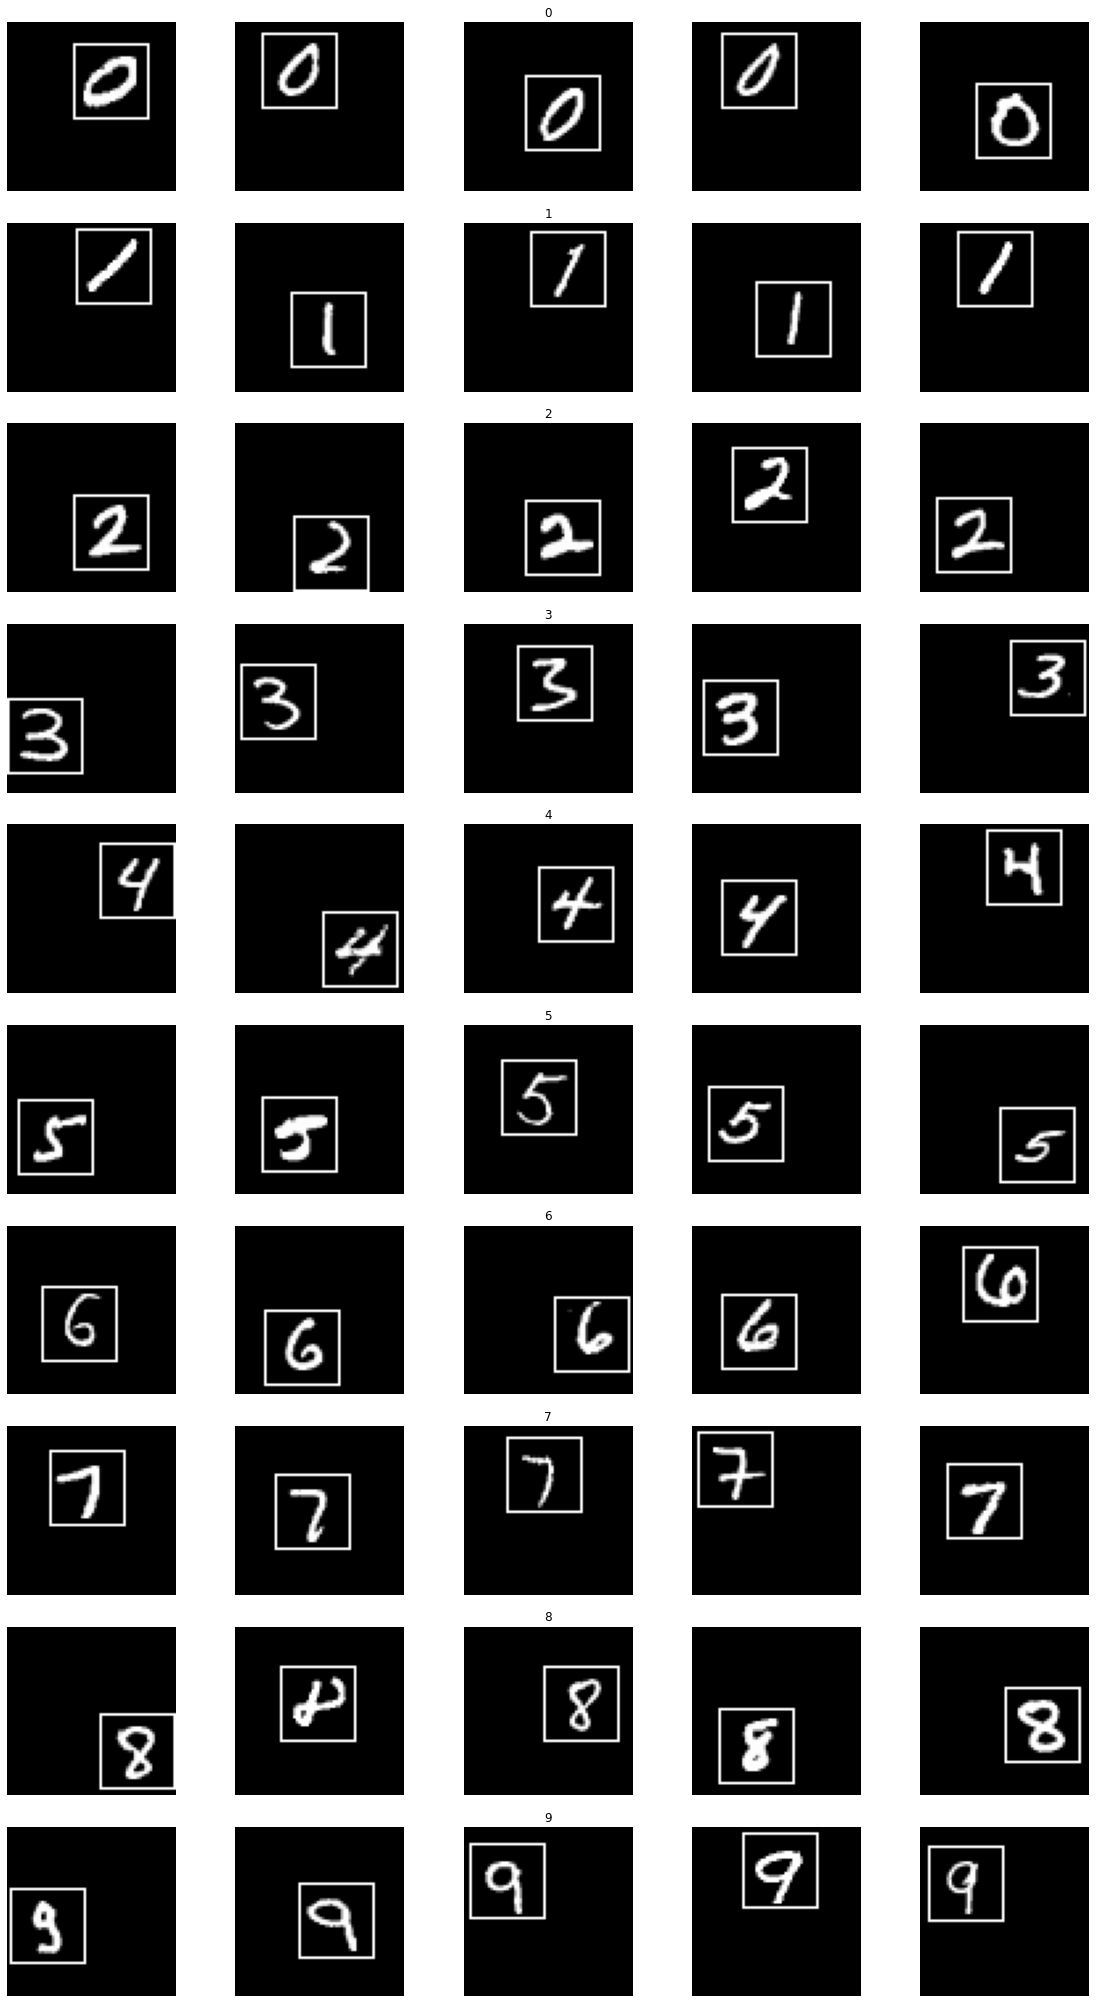

In [8]:
num_of_samples=[]

cols = 5
num_classes = 10

#fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,10))
fig, axis = plt.subplots ( nrows = num_classes, ncols = cols, figsize = (16, 28) )
fig.tight_layout()
     
for i in range(cols):
    for j in range(num_classes):
        classIndicies = (y_train == j)
        x_selected = X_train[ classIndicies ]
        rnd_index = random.randint( 0, len( x_selected ) - 1 )

        x_off = X_train_x[ classIndicies ][ rnd_index ]
        y_off = X_train_y[ classIndicies ][ rnd_index ]

        points = [
            ( x_off, y_off ),
            ( x_off + source_x_size, y_off + source_y_size )
        ]
        data = x_selected[ rnd_index, :, : ].copy()
        img = Image.fromarray(data)
        draw = ImageDraw.Draw(img)
        draw.rectangle(points, fill=None, outline=255)
        new_data = np.asarray(img)
        
        #cv2.rectanlge(img, 2, 2, 10, 10, 255, 1)
    
        axis[j][i].imshow( new_data, cmap = plt.get_cmap( "gray" ) )
        axis[j][i].axis( "off" ) 
        if i == 2:
            axis[j][i].set_title( str( j ) )
            num_of_samples.append( len ( x_selected ) )        

[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]


Text(0, 0.5, 'Number of samples / images')

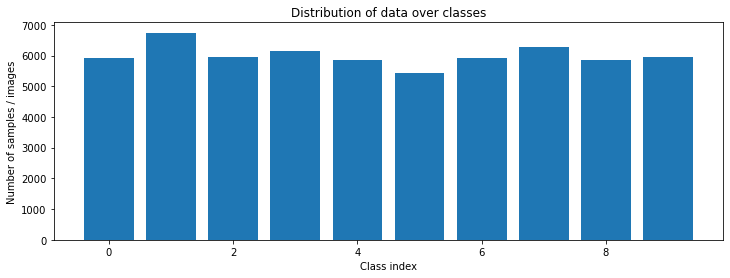

In [9]:
print( num_of_samples )
plt.figure( figsize = ( 12, 4 ) )
plt.bar( range( 0, num_classes), num_of_samples )
plt.title( "Distribution of data over classes" )
plt.xlabel( "Class index" )
plt.ylabel( "Number of samples / images" )

In [10]:
X_train_reshaped = X_train.reshape( ( X_train.shape[ 0 ], X_train.shape[ 1 ], X_train.shape[ 2 ], 1 ) )
X_test_reshaped = X_test.reshape( ( X_test.shape[ 0 ], X_test.shape[ 1 ], X_test.shape[ 2 ], 1 ) )
print( X_train_reshaped.shape )
print( X_test_reshaped.shape )

(60000, 64, 64, 1)
(10000, 64, 64, 1)


In [11]:
y_train_categorical = to_categorical( y_train, num_classes )
y_test_categorical = to_categorical( y_test, num_classes )

In [12]:
X_train_normalized = X_train_reshaped / 255
X_test_normalized = X_test / 255

X_train_reshaped_normalized = X_train_reshaped / 255
X_test_reshaped_normalized = X_test_reshaped / 255

In [13]:
X_train_reshaped_data = np.asarray(X_train_reshaped_normalized)
X_train_data = np.asarray(X_train_normalized)
x_train_offs_data = np.asarray(X_train_x)
y_train_offs_data = np.asarray(X_train_y)
y_train_data = np.asarray(y_train_categorical)

X_test_reshaped_data = np.asarray(X_test_reshaped_normalized)
x_test_offs_data = np.asarray(X_test_x)
y_test_offs_data = np.asarray(X_test_y)
y_test_data = np.asarray(y_test_categorical)

In [21]:
def leNet_model():
    model = Sequential()
    model.add(Conv2D( 30, ( 5, 5 ), input_shape = (X_train_normalized.shape[1], X_train_normalized.shape[2], 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D( 15, ( 3, 3 ), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [22]:
leNet = leNet_model()
print ( leNet.summary() )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 60, 60, 30)        780       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 30)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 15)        4065      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 15)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2940)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               1470500   
_________________________________________________________________
dense_9 (Dense)              (None, 10)               

In [23]:
h_numclass = leNet.fit(X_train_data, y_train_data, epochs=10, validation_split=0.1, batch_size=400, verbose=1, shuffle=1)

ResourceExhaustedError: OOM when allocating tensor with shape[54000,64,64,1] and type double on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:GatherV2]

In [18]:
del h_numclass
del leNet

In [14]:
def leNet_model_coord():
    model = Sequential()
    model.add( Convolution2D( 24, 5, 2, input_shape = ( X_train_normalized.shape[1], X_train_normalized.shape[2], 1 ), activation = 'elu' ) )
    model.add( Convolution2D( 36, 5, 2, activation = 'elu' ) )
    model.add( Convolution2D( 48, 5, 2, activation = 'elu' ) )
    model.add( Convolution2D( 64, 3, activation = 'elu' ) )
    model.add( Convolution2D( 64, 3, activation = 'elu' ) )
    #model.add( Dropout( 0.5 ) )

    model.add( Flatten() )
    model.add( Dense( 100, activation = 'elu' ) )
    #model.add( Dropout( 0.5 ) )

    model.add( Dense( 50, activation = 'elu' ) )
    #model.add( Dropout( 0.5 ) )

    model.add( Dense( 10, activation = 'elu' ) )
    #model.add( Dropout( 0.5 ) )

    model.add( Dense(1) )

    optimizer = Adam( lr = 1e-3 )
    #optimizer = runai.ga.keras.optimizers.Optimizer( optimizer, 8 )
    model.compile( optimizer, loss = 'mse' )
    return model

In [18]:
leNet_coord = leNet_model_coord()
print ( leNet_coord.summary() )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 24)        624       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 48)          43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 1, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

In [19]:
h_xoffs = leNet_coord.fit(
    X_train_data, x_train_offs_data,
    steps_per_epoch = 300,
    epochs = 30,
    validation_split=0.1,
    verbose = 1,
    shuffle = 1)

Epoch 1/30
300/300 [==============================] - 3s 11ms/step - loss: 13.2708 - val_loss: 0.2641

In [20]:
del h_xoffs
del leNet_coord

In [15]:
leNet_coord = leNet_model_coord()
print ( leNet_coord.summary() )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 24)        624       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 48)          43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               6

In [16]:
h_yoffs = leNet_coord.fit(
    X_train_data, y_train_offs_data,
    steps_per_epoch = 300,
    epochs = 30,
    validation_split=0.1,
    verbose = 1,
    shuffle = 1)

Epoch 1/30
300/300 [==============================] - 3s 11ms/step - loss: 17.5485 - val_loss: 0.5541

In [17]:
del h_yoffs
del leNet_coord

In [ ]:
plt.plot( h.history[ 'loss' ] )
plt.plot( h.history[ 'val_loss' ])
plt.legend( [ 'loss', 'val_loss' ] )
plt.title( 'loss' )
plt.xlabel( 'epoch' )

Text(0.5, 0, 'epoch')

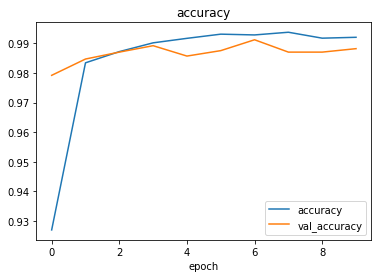

In [18]:
plt.plot( h.history[ 'accuracy' ] )
plt.plot( h.history[ 'val_accuracy' ])
plt.legend( [ 'accuracy', 'val_accuracy' ] )
plt.title( 'accuracy' )
plt.xlabel( 'epoch' )

In [19]:
score = leNet.evaluate( X_test_data, y_test_data, verbose=0 )
print( type( score ) )
print( "Test score:", score[ 0 ] )
print( "Test accuracy:", score[ 1 ] )

<class 'list'>
Test score: 0.04964568093419075
Test accuracy: 0.9866999983787537


In [22]:
import cv2
from PIL import Image

import requests
from PIL import Image
url = "https://colah.github.io/posts/2014-10-Visualizing-MNIST/img/mnist_pca/MNIST-p1815-4.png"
response = requests.get( url, stream=True )
print( response )
img = Image.open( response.raw )

#for x in range(0,10):
#    filename = "Image/" + str(x) + ".png"
#    img = Image.open( filename )
#-----------------------------------------------
img_array = np.asarray( img )
img_resized = cv2.resize( img_array, ( 28, 28 ) )
gray_scale = cv2.cvtColor( img_resized, cv2.COLOR_BGR2GRAY)
img_inv = cv2.bitwise_not( gray_scale )
#-----------------------------------------------
image = img_inv / 255
image = image.reshape( 1, 28, 28, 1 )
#-----------------------------------------------
prediction = np.argmax( leNet.predict( image ), axis=-1)
print( "predicted digit:", str( prediction ) )
#    if( prediction != x ):
#        plt.imshow( img_inv, cmap = plt.get_cmap( "gray" ) )
#        print("WRONG PREDICTION!")


<Response [200]>
predicted digit: [2]
